## K-means Clustering Using PCA

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium 

import sklearn
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import GridSearchCV
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score

from collections import Counter

import yellowbrick
from yellowbrick.cluster import KElbowVisualizer

In [124]:
# load species data for each park

species = pd.read_csv('all_species.csv')

/var/folders/vb/bprs19k12d92r7xpmxnv1rx40000gn/T/ipykernel_22650/710985686.py:3: DtypeWarning: Columns (3,12,14,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  species = pd.read_csv('all_species.csv')


In [127]:
# load location data for each park

locations = pd.read_csv('locations.csv')


In [128]:
# new df with only species that are present 
present_sp = species[species['Occurrence'] == 'Present']

abundance_df = present_sp[['Park Name', 'Scientific Name', 'Abundance', 'Occurrence']]
abundance_df['Abundance'].value_counts()

Unknown       44988
Uncommon      26914
Common        20533
Rare          15223
Occasional     4277
Abundant       3920
Name: Abundance, dtype: int64

#### Calculating Cosine Similarity between Parks

In [129]:
similarity_df = present_sp[['Park Name', 'Scientific Name', 'Park Code']]

In [130]:
# like of all park codes
park_codes = list(similarity_df['Park Code'].unique())

# list of all species in a park
code_sp_list = []
for code in park_codes:
    sp = list(similarity_df[similarity_df['Park Code'] == code]['Scientific Name'])
    #sp.append(code)
    code_sp_list.append(sp)

# new park-species dataframe
park_sp_df = pd.DataFrame()
park_sp_df['park_code'] = park_codes
park_sp_df['species_list'] = code_sp_list
park_sp_df.head()

,park_code,species_list
0,ACAD,"[Alces alces, Odocoileus virginianus, Canis la..."
1,ARCH,"[Antilocapra americana, Ovis canadensis, Cervu..."
2,BADL,"[Antilocapra americana, Bison bison, Ovis cana..."
3,BIBE,"[Antilocapra americana, Ammotragus lervia, Ovi..."
4,BISC,"[Odocoileus virginianus, Urocyon cinereoargent..."


In [133]:
# 0 if species is not present, 1 if species is present
mlb = MultiLabelBinarizer()
vec = mlb.fit_transform(park_sp_df['species_list'])
vecs = pd.DataFrame(vec, columns=mlb.classes_)
vecs

,Abacidus,Abaeis nicippe,Abagrotis placida,Abedus,Abedus indentatus,Abelia X grandiflora,Abgrallaspis cyanophylli,Abies X shastensis,Abies amabilis,Abies balsamea,...,Zuckia brandegei var. plummeri,Zygodon reinwardtii,Zygodon rubrigemmius,Zygodon tetragonostomus,Zygodon viridissimus,Zygodon viridissimus var. rupestris,"nr. Bledius, sp.111",nr. Cercyon sp. 26,ormosia scleroprocta,physa virgata
0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
56,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
57,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [134]:
# apply cosine_similarity fxn on df
df_cosine = pd.DataFrame(cosine_similarity(vecs,dense_output=True))

# pca for dimensitonality reduction
pca = PCA(4)
transform = pca.fit_transform(df_cosine)
transform[0:5]

array([[ 0.31699138,  0.2161492 ,  0.69123366, -0.04726192],
       [-0.90675793, -0.32720328, -0.03646262, -0.29172927],
       [-0.43496231, -0.08495991,  0.32525284, -0.17207732],
       [-0.55762755,  0.18220456, -0.17063646, -0.38509073],
       [ 0.21039641,  0.87829246, -0.52365182, -0.22314064]])

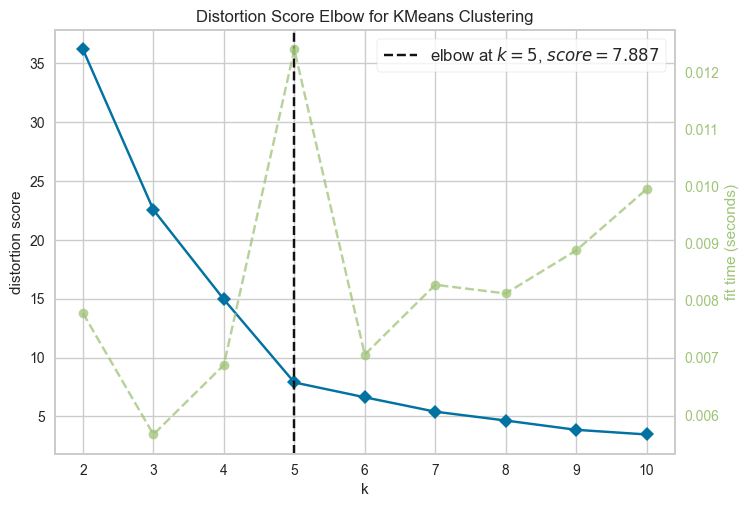

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [135]:
# elbow plot
visualizer = KElbowVisualizer(KMeans(random_state = 42), k=(2,11))

visualizer.fit(transform) # Fit the data to the visualizer
visualizer.show()

### K-means Clustering

In [136]:
# use grid search cv to get optimal hyperparameters
model = KMeans()
param_search = { 
    'n_clusters': [3,4,5,6,7,8],
    'init': ['k-means++', 'random'],
    'n_init' : [5, 10, 15],
    'max_iter' : [100, 200, 300, 400]
}
#tscv = TimeSeriesSplit()
gsearch = GridSearchCV(estimator=model, param_grid=param_search)

gsearch.fit(transform)
best_score = gsearch.best_score_
best_model = gsearch.best_estimator_
best_model

KMeans(init='random', max_iter=200)

In [137]:
k_means = KMeans(n_clusters=5, random_state = 42)

# get cluster labels for each park
label = k_means.fit_predict(transform)

u_labels = np.unique(label)

# add cluster label to park
park_sp_df['k_cluster'] = label
k_clus_loc = park_sp_df.merge(locations, how = 'left', left_on = 'park_code', right_on = 'Park Code')
k_clus_loc

,park_code,species_list,k_cluster,Unnamed: 0,Park Code,Park Name,State,Acres,Latitude,Longitude,present
0,ACAD,"[Alces alces, Odocoileus virginianus, Canis la...",0,0,ACAD,Acadia National Park,ME,47390,44.3500,-68.2100,1
1,ARCH,"[Antilocapra americana, Ovis canadensis, Cervu...",1,1,ARCH,Arches National Park,UT,76519,38.6800,-109.5700,1
2,BADL,"[Antilocapra americana, Bison bison, Ovis cana...",1,2,BADL,Badlands National Park,SD,242756,43.7500,-102.5000,1
3,BIBE,"[Antilocapra americana, Ammotragus lervia, Ovi...",1,3,BIBE,Big Bend National Park,TX,801163,29.2500,-103.2500,1
4,BISC,"[Odocoileus virginianus, Urocyon cinereoargent...",4,4,BISC,Biscayne National Park,FL,172924,25.6500,-80.0800,1
...,...,...,...,...,...,...,...,...,...,...,...
56,INDU,"[Odocoileus virginianus, Canis familiaris, Can...",0,56,INDU,Indiana Dunes National Park,IN,15066,41.6506,-87.0708,0
57,NPSA,"[Sus scrofa, Felis catus, Megaptera novaeangli...",4,57,NPSA,National Park of American Samoa,AS,13500,14.2583,170.6833,0
58,NERI,"[Odocoileus virginianus, Canis latrans, Canis ...",0,58,NERI,New River Gorge National Park,WV,72808,37.8752,-81.0357,0
59,VIIS,"[Capra hircus, Odocoileus virginianus, Sus scr...",4,59,VIIS,Virgin Islands National Park,VI,12909,18.3435,64.7501,0


In [138]:
location_list = k_clus_loc[['Latitude', 'Longitude']].values.tolist()
park_names = k_clus_loc['Park Name'].tolist()

# assign colors to each cluster
def regioncolors(counter):
    if counter['k_cluster'] == 0:
        return 'darkblue'
    elif counter['k_cluster'] == 1:
        return 'darkred'
    elif counter['k_cluster'] == 2:
        return 'blue'
    elif counter['k_cluster'] == 3:
        return 'darkgreen'
    else:
        return 'darkpurple'
        
k_clus_loc['color'] = k_clus_loc.apply(regioncolors, axis = 1)
k_clus_loc[k_clus_loc['k_cluster'] == 4]
k_clus_loc = k_clus_loc.dropna().reset_index(drop = True)

In [141]:
us_map = folium.Map(tiles='CartoDB positron', zoom_start=14)

for point in range(0, len(location_list)):
    folium.Marker(location_list[point],popup=park_names[point], icon=folium.Icon(color=k_clus_loc["color"][point], icon_color='white', icon='star', angle=0, prefix='fa')).add_to(us_map)

display(us_map)

### Evaluation

In [142]:
silhouette_score(transform, k_means.fit_predict(transform)) # a good silhouette score should be > 0.5

0.5606161269887898

Silhouette Score for k =  2 is 0.34174901018141196
Silhouette Score for k =  3 is 0.4544113900215037
Silhouette Score for k =  4 is 0.47236029194201207
Silhouette Score for k =  5 is 0.5606161269887898
Silhouette Score for k =  6 is 0.5482662942704468
Silhouette Score for k =  7 is 0.5028812520891954
Silhouette Score for k =  8 is 0.5333837278670028
Silhouette Score for k =  9 is 0.5071850575082979
Silhouette Score for k =  10 is 0.5144575406679242


Text(0, 0.5, 'Silhouette score')

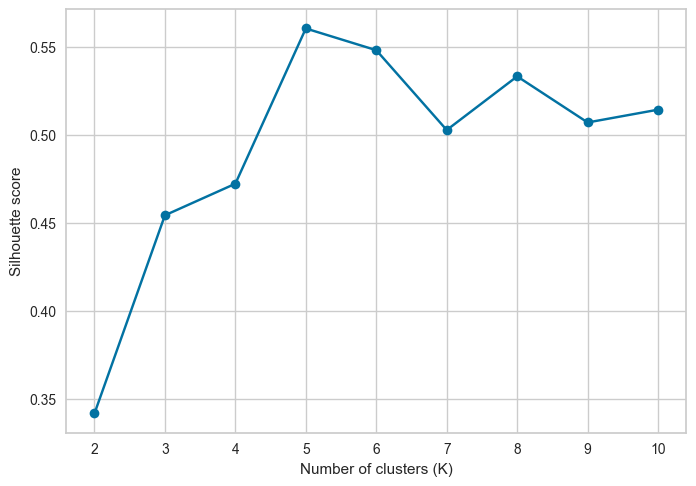

In [143]:
silhouette_scores = []

for k in range(2, 11):
    model2 = KMeans(n_clusters=k, random_state=42)
    model2.fit(transform)
    score = silhouette_score(transform, model2.labels_)
    print("Silhouette Score for k = ", k, "is", score)
    silhouette_scores.append(score)
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette score')

Text(0.5, 1.0, 'K-means Clusters')

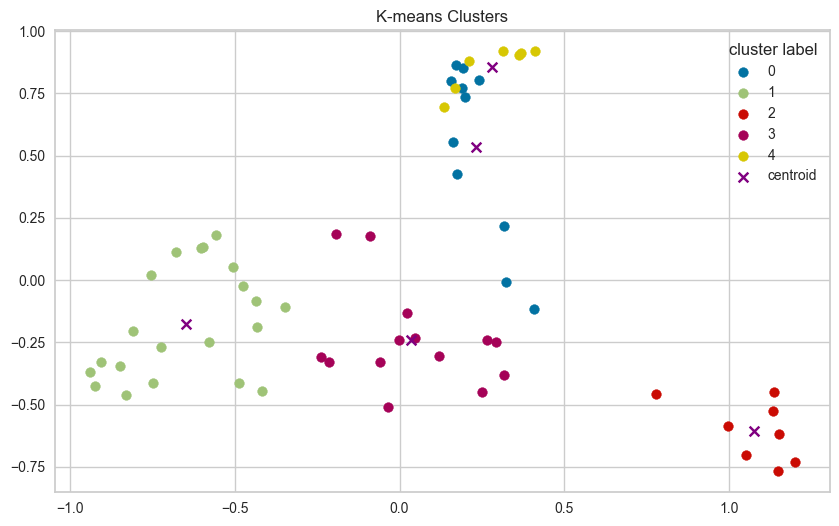

In [144]:
colors = ['darkblue', 'darkred', 'blue', 'darkgreen', 'purple']
plt.figure(figsize=(10,6))
for i in u_labels:
    plt.scatter(transform[label == i , 0] , transform[label == i , 1] , label = i)
plt.scatter(k_means.cluster_centers_[:,0],k_means.cluster_centers_[:,1],color='purple',marker='x',label='centroid')
plt.legend(title = 'cluster label')
plt.title('K-means Clusters')

In [145]:
from sklearn.metrics import davies_bouldin_score

davies_bouldin_score(transform, k_means.fit_predict(transform))

0.6103884155460552

In [146]:
from sklearn.metrics import calinski_harabasz_score
calinski_harabasz_score(transform, k_means.fit_predict(transform))

77.99305464867618